In [2]:
import pandas as pd
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import pandas as pd
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier

# EDA

In [3]:
df = pd.read_csv("/home/heylucasleao/ols-regression-challenge/data/INFLUD24-03-02-2025.csv", sep=";", encoding="latin1", low_memory=False)

In [4]:
sinais_sintomas = [
    "FEBRE", "TOSSE", "GARGANTA", "DISPNEIA", "DESC_RESP", 
    "SATURACAO", "DIARREIA", "VOMITO", "DOR_ABD", "FADIGA", 
    "PERD_OLFT", "PERD_PALA", "OUTRO_SIN", 
    #"OUTRO_DES"
]
fatores_risco = [
    "FATOR_RISC", 
    #"PUERPERA", 
    "CARDIOPATI", 
    #"HEMATOLOGI", 
    #"SIND_DOWN", 
    #"HEPATICA", 
    "ASMA", 
    "DIABETES", 
    "NEUROLOGIC", 
    "PNEUMOPATI", 
    "IMUNODEPRE", 
    #"RENAL", 
    #"OBESIDADE", 
    #"OBES_IMC", 
    "OUT_MORBI", 
    #"MORB_DESC"
]
vacinacao = [
    "VACINA_COV", 
    #"DOSE_1_COV", 
    #"DOSE_2_COV", 
    #"DOSE_REF", 
    #"DOSE_2REF", 
    #"FAB_COV1", 
    #"FAB_COV2", 
    #"FAB_COVRF", 
    #"FAB_COVRF2", 
    #"LOTE_1_COV", 
    #"LOTE_2_COV", 
    #"LOTE_REF", 
    # "LOTE_REF2", 
    #"FNT_IN_COV"
]
tratamento = [
    "ANTIVIRAL", 
    #"TP_ANTIVIR", "OUT_ANTIV", "DT_ANTIVIR", 
    #"TRAV_COV", 
    #"TIPO_TRAV", 
    #"OUT_TRAV", 
    #"DT_TRAV_COV"
]

internacao = [
    "HOSPITAL", 
    #"DT_INTERNA", 
    #"SG_UF_INTE", 
    #"CO_MU_INTE", 
    #"CO_UN_INTE", 
    "UTI", 
    #"DT_ENTUTI", 
    #"DT_SAIDUTI", 
    "SUPORT_VEN"
]
exames = [
    "RAIOX_RES", 
    #"RAIOX_OUT", 
    #"DT_RAIOX", 
    "TOMO_RES", 
   # "TOMO_OUT", 
    #"DT_TOMO", 
    "AMOSTRA", 
    #"DT_COLETA", 
    "TP_AMOSTRA", 
    #"OUT_AMOST"
]
testes_laboratoriais = [
    "RES_AN", 
    #"POS_AN_FLU", 
    #"TP_FLU_AN", 
    #"POS_AN_OUT", 
    #"AN_SARS2", 
    #"AN_VSR", 
    #"AN_PARA1", 
    #"AN_PARA2", 
    #"AN_PARA3", 
    #"AN_ADENO", 
    #"AN_OUTRO", 
    #"DS_AN_OUT"
]
rt_pcr = [
    "PCR_RESUL", 
    #"DT_PCR", 
    "POS_PCRFLU", 
    #"TP_FLU_PCR", 
    #"PCR_FLUASU", 
    #"FLUASU_OUT", 
    #"PCR_FLUBLI", 
    #"FLUBLI_OUT", 
    "POS_PCROUT",
    #"PCR_SARS2", 
    #"PCR_VSR", 
    #"PCR_PARA1", 
    #"PCR_PARA2", 
    #"PCR_PARA3", 
    #"PCR_PARA4", 
    #"PCR_ADENO", 
    #"PCR_METAP", 
    #"PCR_BOCA", 
    #"PCR_RINO", 
    #"PCR_OUTRO", 
    #"DS_PCR_OUT"
]


In [5]:
columns = (sinais_sintomas 
            + fatores_risco 
            + vacinacao 
            + tratamento 
            + internacao
            + exames
            + testes_laboratoriais
            + rt_pcr)
target = "CASO_SRAG"

In [717]:
df = df[columns + ["CASO_SRAG"]]

In [718]:
is_null = df.isnull().sum()
remove_features = is_null[is_null / len(df) > 0.70].index.tolist()
df = df[df.columns.drop(remove_features)]

In [719]:
(df.isnull().sum() / len(df)).sort_values(ascending=False)

IMUNODEPRE    0.695856
NEUROLOGIC    0.691754
PNEUMOPATI    0.691476
ASMA          0.687209
POS_PCRFLU    0.685441
DIABETES      0.676996
POS_PCROUT    0.670232
OUT_MORBI     0.666411
CARDIOPATI    0.658409
TOMO_RES      0.413032
RAIOX_RES     0.311369
OUTRO_SIN     0.273663
PERD_PALA     0.259017
PERD_OLFT     0.257681
DOR_ABD       0.249405
GARGANTA      0.242386
DIARREIA      0.240408
VOMITO        0.233641
FADIGA        0.233330
ANTIVIRAL     0.191679
SATURACAO     0.150790
DESC_RESP     0.119487
DISPNEIA      0.110783
SUPORT_VEN    0.109432
CASO_SRAG     0.109151
FEBRE         0.105394
RES_AN        0.102488
UTI           0.100743
PCR_RESUL     0.078279
TP_AMOSTRA    0.075052
TOSSE         0.065053
HOSPITAL      0.022456
AMOSTRA       0.020666
VACINA_COV    0.000191
FATOR_RISC    0.000000
dtype: float64

In [6]:
def corr_heatmap(df, width=1600, height=1600, fig_type=None):
    """   
    Generate a correlation heatmap for the DataFrame.
    """
    fig = px.imshow(df.corr(numeric_only=True), text_auto=True, aspect="equal", color_continuous_scale='RdBu_r', title='Heatmap of Correlation Coefficients')
    fig.update_layout(width=width, height=height)
    return fig.show(fig_type)

# Preprocessing

In [721]:
df = df.fillna(9)
df = df.replace({9: -1})
df = pd.get_dummies(df, columns=df.columns.drop("CASO_SRAG"), drop_first=True)
df = df.astype(int)
df = df[(df["CASO_SRAG"] > -1)]

In [722]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

## Partialling-Out / Residualization (FWL Theorem)

In [723]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import check_array
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureResidualizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        """Feature transformer that reduces multicollinearity by residualizing highly correlated features.
    
        For each feature strongly correlated (above `corrcoef` threshold) with others, this class:
        1. Fits a linear regression model using the correlated features as predictors.
        2. Replaces the original feature with residuals (observed - predicted) from the model,
        effectively removing linear dependencies.
        
        Useful as a preprocessing step for linear models where multicollinearity is problematic.
        
        Attributes
        ----------
        models_ : Dict[int, Dict[str, Any]]
            Dictionary storing residualization models for each processed feature.
            Keys are feature indices; values are dicts with:
            - "model": Fitted `LinearRegression` object.
            - "features": Indices of features used as predictors.
        feature_names_in_ : Optional[np.ndarray]
            Names of input features if provided in a pandas DataFrame.
        n_features_in_ : Optional[int]
            Number of features seen during fit.

        Notes
        -----
        - Computes absolute Pearson correlations between all feature pairs (ignoring self-correlations)  
        - Processes features in descending order of total correlation with others  
        - For each target feature:  
          - Selects correlated predictors (≥ threshold) not yet residualized  
          - Fits linear model: target ~ predictors  
          - Replaces target feature with model residuals  
          - Excludes residualized features from future predictor sets  
        - Preserves:  
          - Feature order and non-correlated features  
          - Non-linear relationships  
        - Prevents circular dependencies by marking residualized features  
        - Only removes linear relationships between features  

        """
        self.models_ = None
        self.feature_names_in_ = None
        self.n_features_in_ = None

    def fit(self, X: np.ndarray, corrcoef: float = 0.8, processing_order=None):
        """
        Identify feature pairs with absolute correlation ≥ `corrcoef` and prepare residualization models.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input data. Can be a pandas DataFrame (preserves column names) or numpy array.
        corrcoef : float, default=0.8
            Absolute correlation threshold for triggering residualization.
            Features with |ρ| ≥ this value will be residualized.
            
        Returns
        -------
        self : FeatureResidualizer
            Fitted transformer.
        """

        self.models_ = {}
        self.feature_names_in_ = getattr(X, 'columns', None)
        X = check_array(X, ensure_2d=True, dtype=np.float64)
        self.n_features_in_ = X.shape[1]
        
        corr = np.abs(np.corrcoef(X, rowvar=False))
        np.fill_diagonal(corr, 0)
        residualized = []
        
        processing_order = np.argsort(-np.sum(corr, axis=1))
        
        for i in processing_order:
            corr_feature = corr[i]
            mask = np.ones(corr_feature.shape, dtype=bool)
            mask[residualized] = False
            indexes = np.argwhere((corr_feature >= corrcoef) & mask).flatten()

            if len(indexes) > 0:
                model = LinearRegression()
                model.fit(X[:, indexes], X[:, i])
  
                self.models_[i] = {"model": model,
                                "features": indexes,
                            }
                residualized.append(i)
        
        return self
    
    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Apply residualization to the input data using pre-trained models.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Data to transform. Must match feature count of `fit()` input.
            
        Returns
        -------
        X_transformed : ndarray of shape (n_samples, n_features)
            Data with residualized features (others remain unchanged).
            
        Raises
        ------
        ValueError
            If number of features in X doesn't match training data.
        """
        
        check_is_fitted(self, 'models_')
        X = check_array(X, ensure_2d=True, dtype=np.float64)
        X = X.copy()
        
        if X.shape[1] != self.n_features_in_:
            raise ValueError(
                f"Expected {self.n_features_in_} features, got {X.shape[1]}"
            )
        
        for i, model_info in self.models_.items():
            model_info = self.models_[i]
            X[:, i] -= model_info["model"].predict(X[:, model_info["features"]])
            
        return X
    
    def fit_transform(self, X: np.ndarray, corrcoef: float = 0.8) -> np.ndarray:
        """Convenience method for fit().transform()."""
        return self.fit(X, corrcoef=corrcoef).transform(X)

In [724]:
dummy_sintomas = []
for sintoma in sinais_sintomas:
    dummy = df.columns[df.columns.str.startswith(sintoma)]
    dummy_sintomas = dummy_sintomas + dummy.tolist()
dummy_fatores_risco = []
for fator in fatores_risco:
    dummy = df.columns[df.columns.str.startswith(fator)]
    dummy_fatores_risco = dummy_fatores_risco + dummy.tolist()

dummy_internacao = []
for inter in internacao:
    dummy = df.columns[df.columns.str.startswith(inter)]
    dummy_internacao = dummy_internacao + dummy.tolist()


In [725]:
y_train = df_train["CASO_SRAG"]
y_test = df_test["CASO_SRAG"]
X_train = df_train[df_train.columns[df_train.columns != target]]
X_test = df_test[df_test.columns[df_test.columns != target]]

### Residualizar Sinais e Sintomas

In [726]:
residualizer = FeatureResidualizer()
residualizer.fit(df_train[dummy_sintomas], corrcoef=0.70)

FeatureResidualizer()

In [727]:
#Train
X_train = X_train.astype({x: float for x in dummy_sintomas})
X_train.loc[:, dummy_sintomas] = residualizer.transform(X_train[dummy_sintomas])

#Test
X_test = X_test.astype({x: float for x in dummy_sintomas})
X_test.loc[:, dummy_sintomas] = residualizer.transform(X_test[dummy_sintomas])

### Residualizar Fatores de Risco

In [728]:
residualizer = FeatureResidualizer()
residualizer.fit(df_train[dummy_fatores_risco], corrcoef=0.70)

FeatureResidualizer()

In [686]:
#Train
X_train = X_train.astype({x: float for x in dummy_fatores_risco})
X_train.loc[:, dummy_fatores_risco] = residualizer.transform(X_train[dummy_fatores_risco])

#Test
X_test = X_test.astype({x: float for x in dummy_fatores_risco})
X_test.loc[:, dummy_fatores_risco] = residualizer.transform(X_test[dummy_fatores_risco])

### Residualizar Internação

In [687]:
residualizer = FeatureResidualizer()
residualizer.fit(df_train[dummy_internacao], corrcoef=0.70)

FeatureResidualizer()

In [688]:
#Train
X_train = X_train.astype({x: float for x in dummy_internacao})
X_train.loc[:, dummy_internacao] = residualizer.transform(X_train[dummy_internacao])

#Test
X_test = X_test.astype({x: float for x in dummy_internacao})
X_test.loc[:, dummy_internacao] = residualizer.transform(X_test[dummy_internacao])

### Sinais e Sintomas

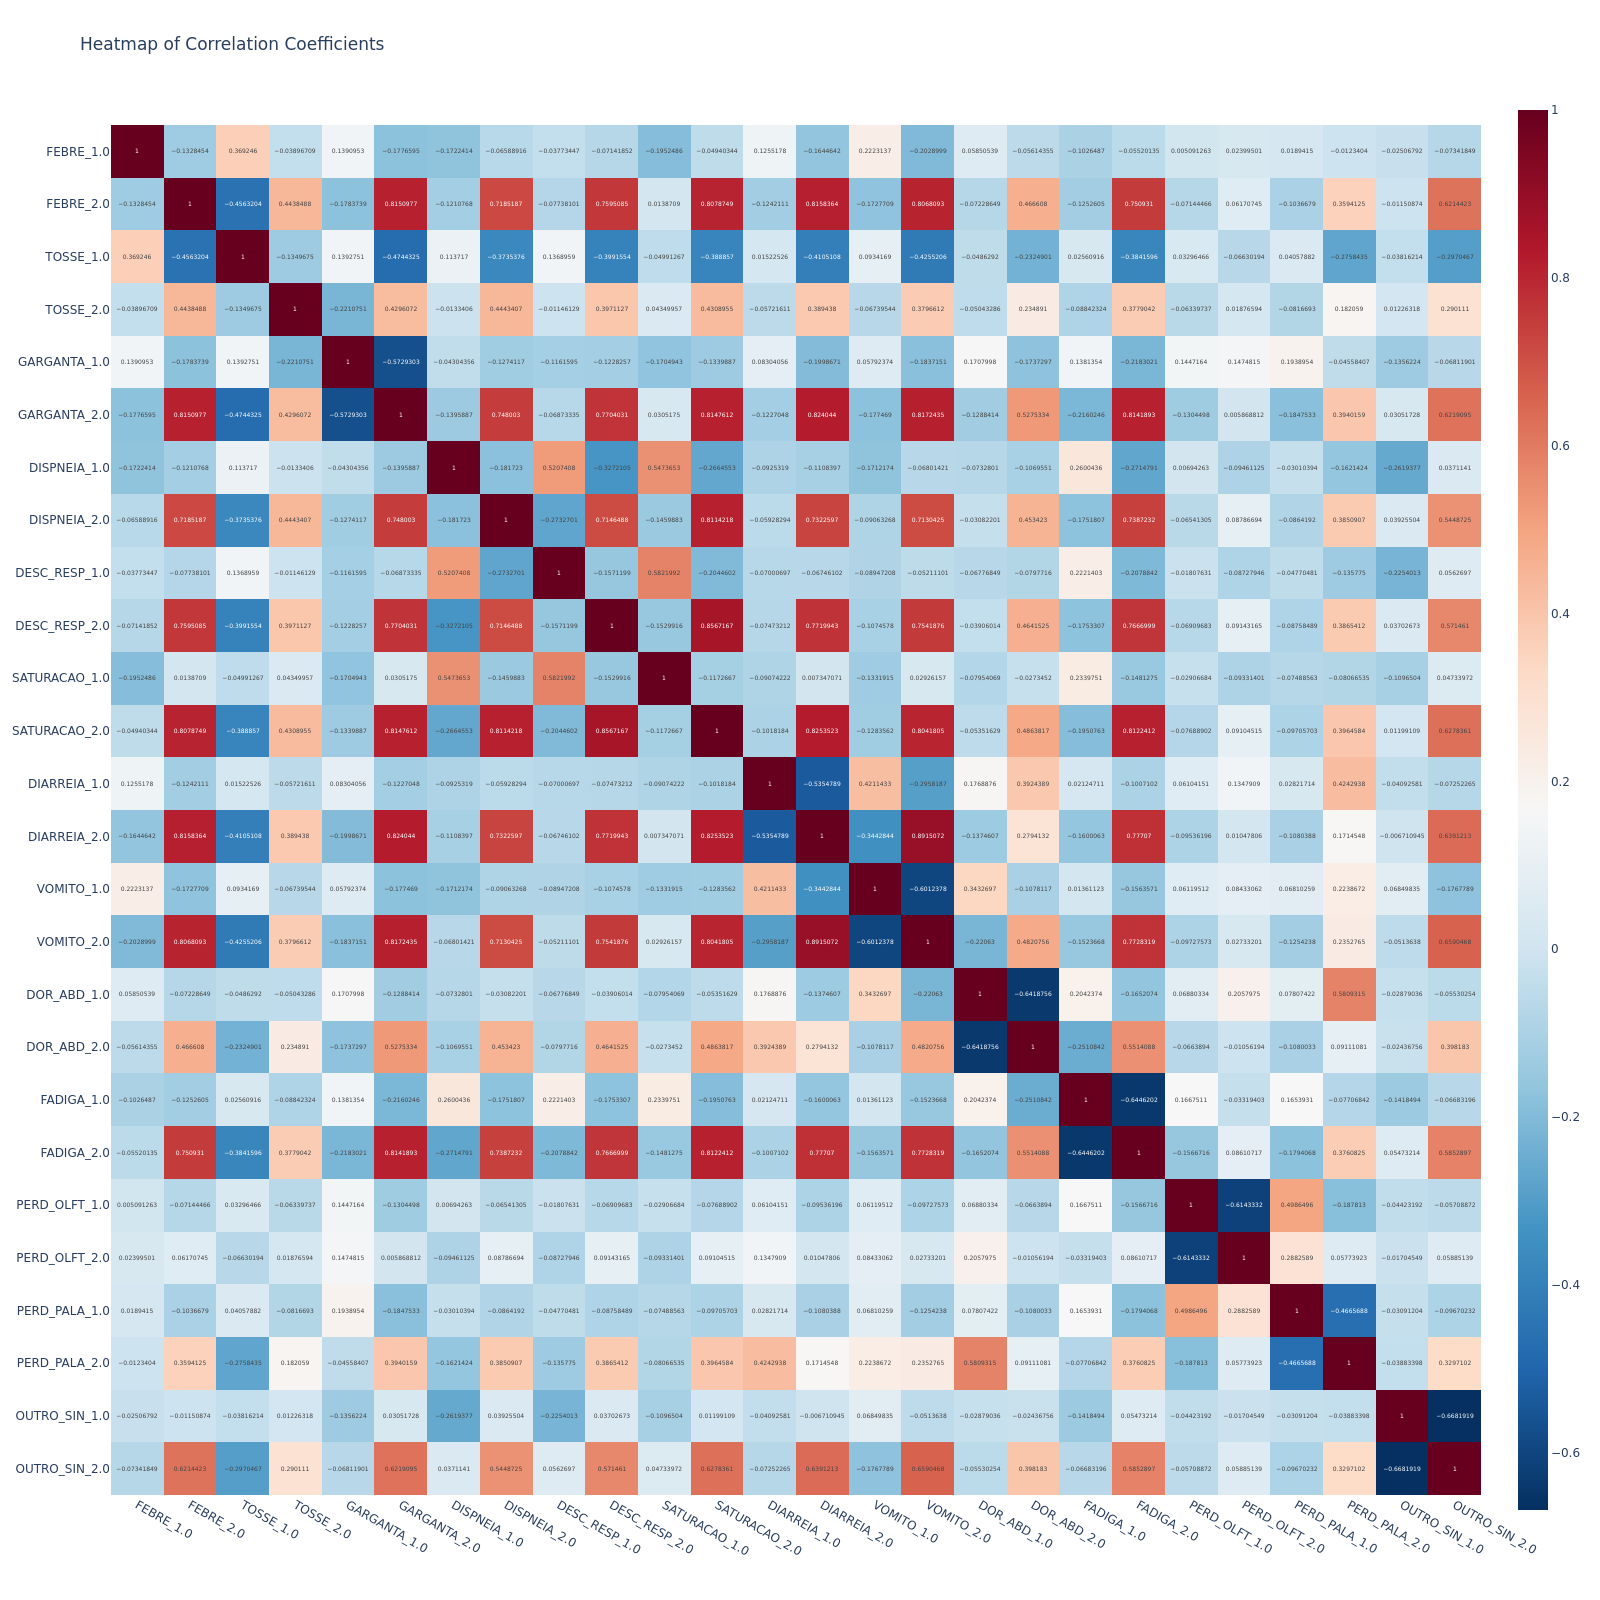

In [689]:
corr_heatmap(X_train.corr(numeric_only=True)[dummy_sintomas], fig_type="png")

### Fatores de Risco

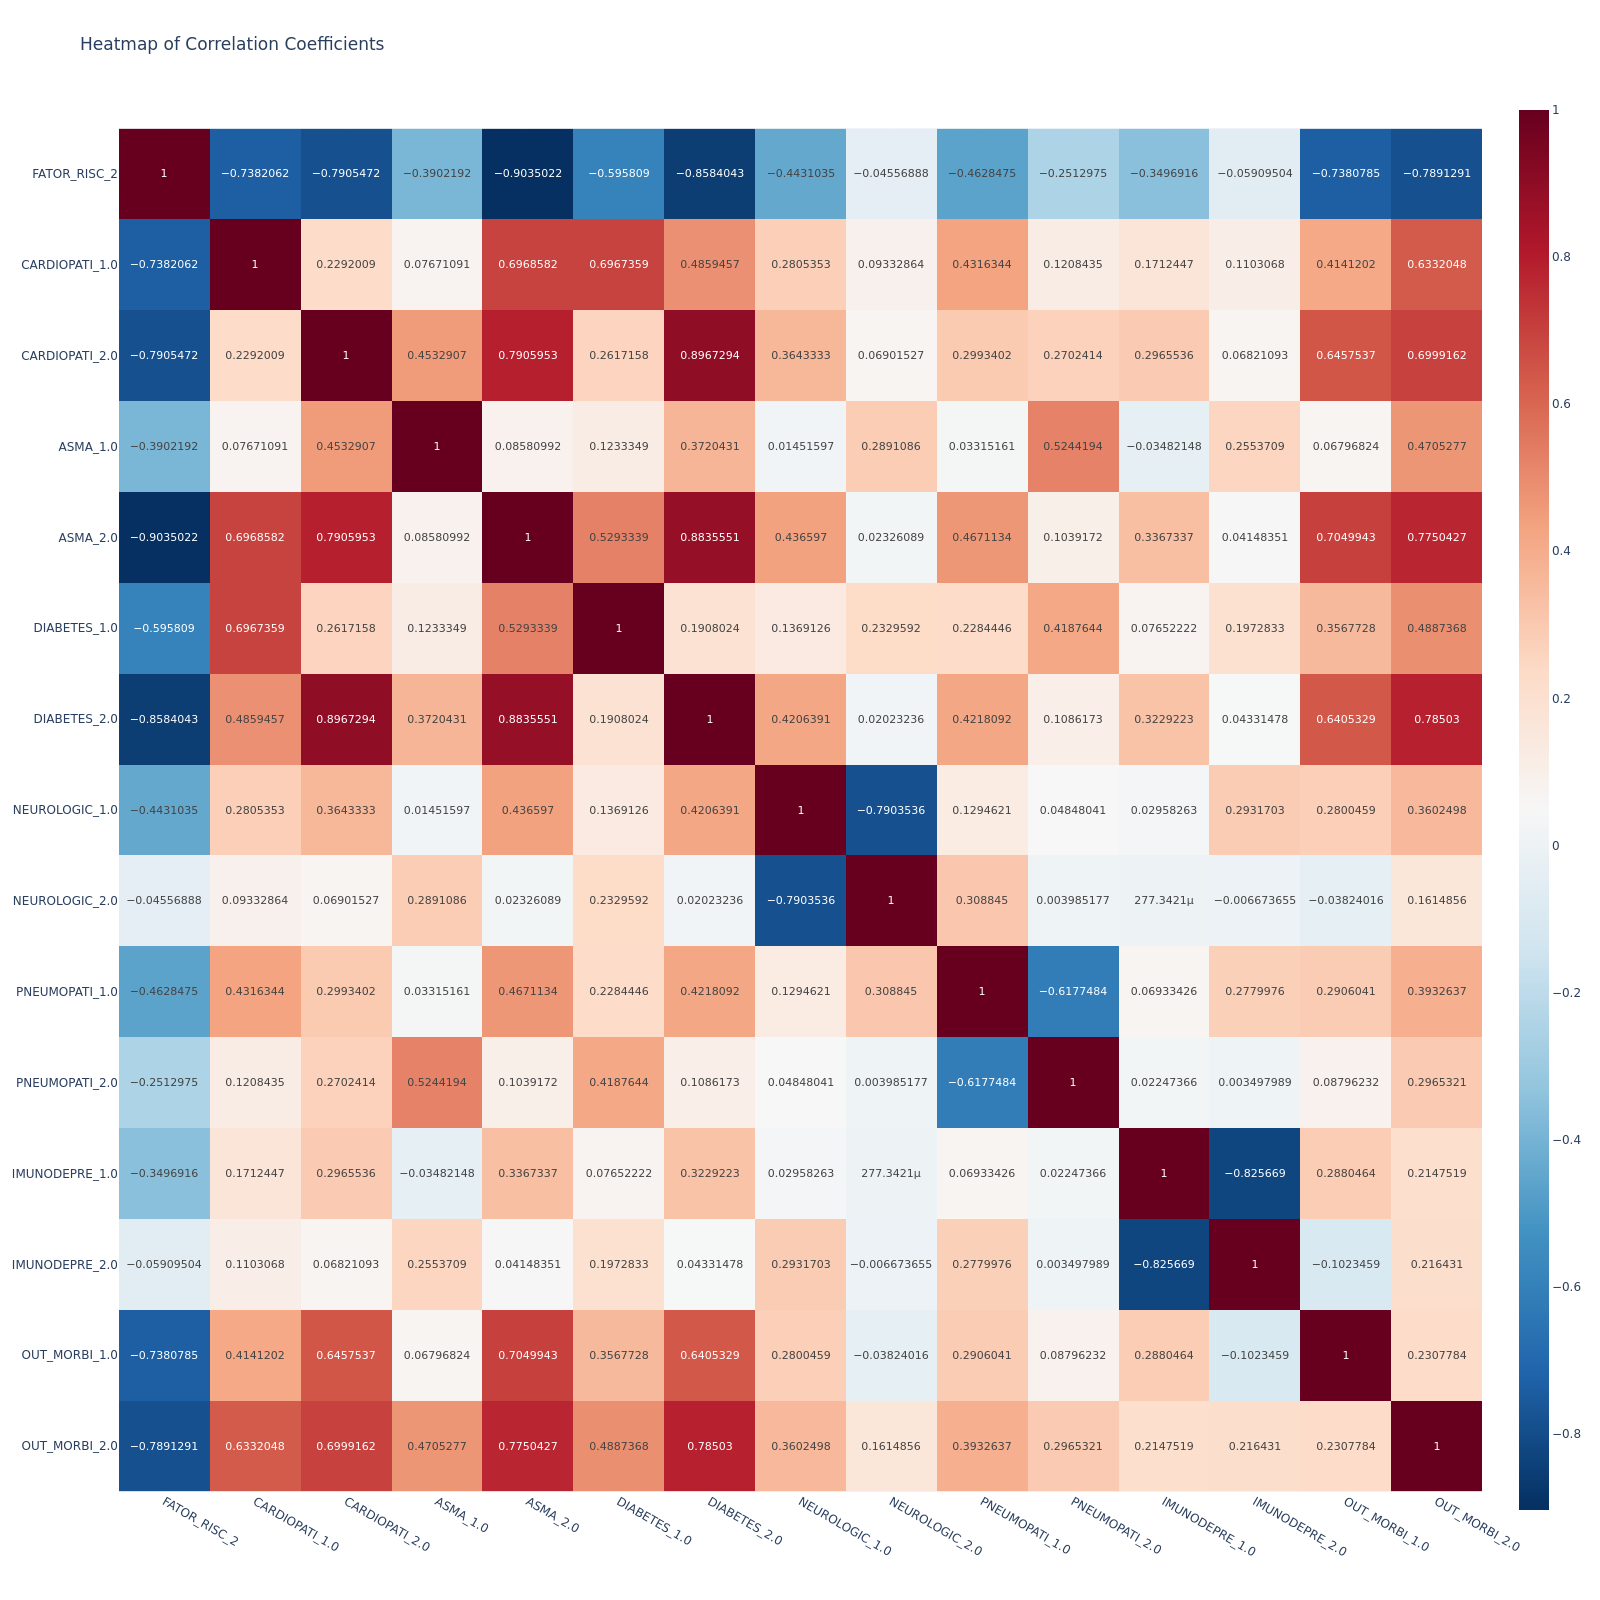

In [690]:
corr_heatmap(X_train.corr(numeric_only=True)[dummy_fatores_risco], fig_type="png")

### Internação

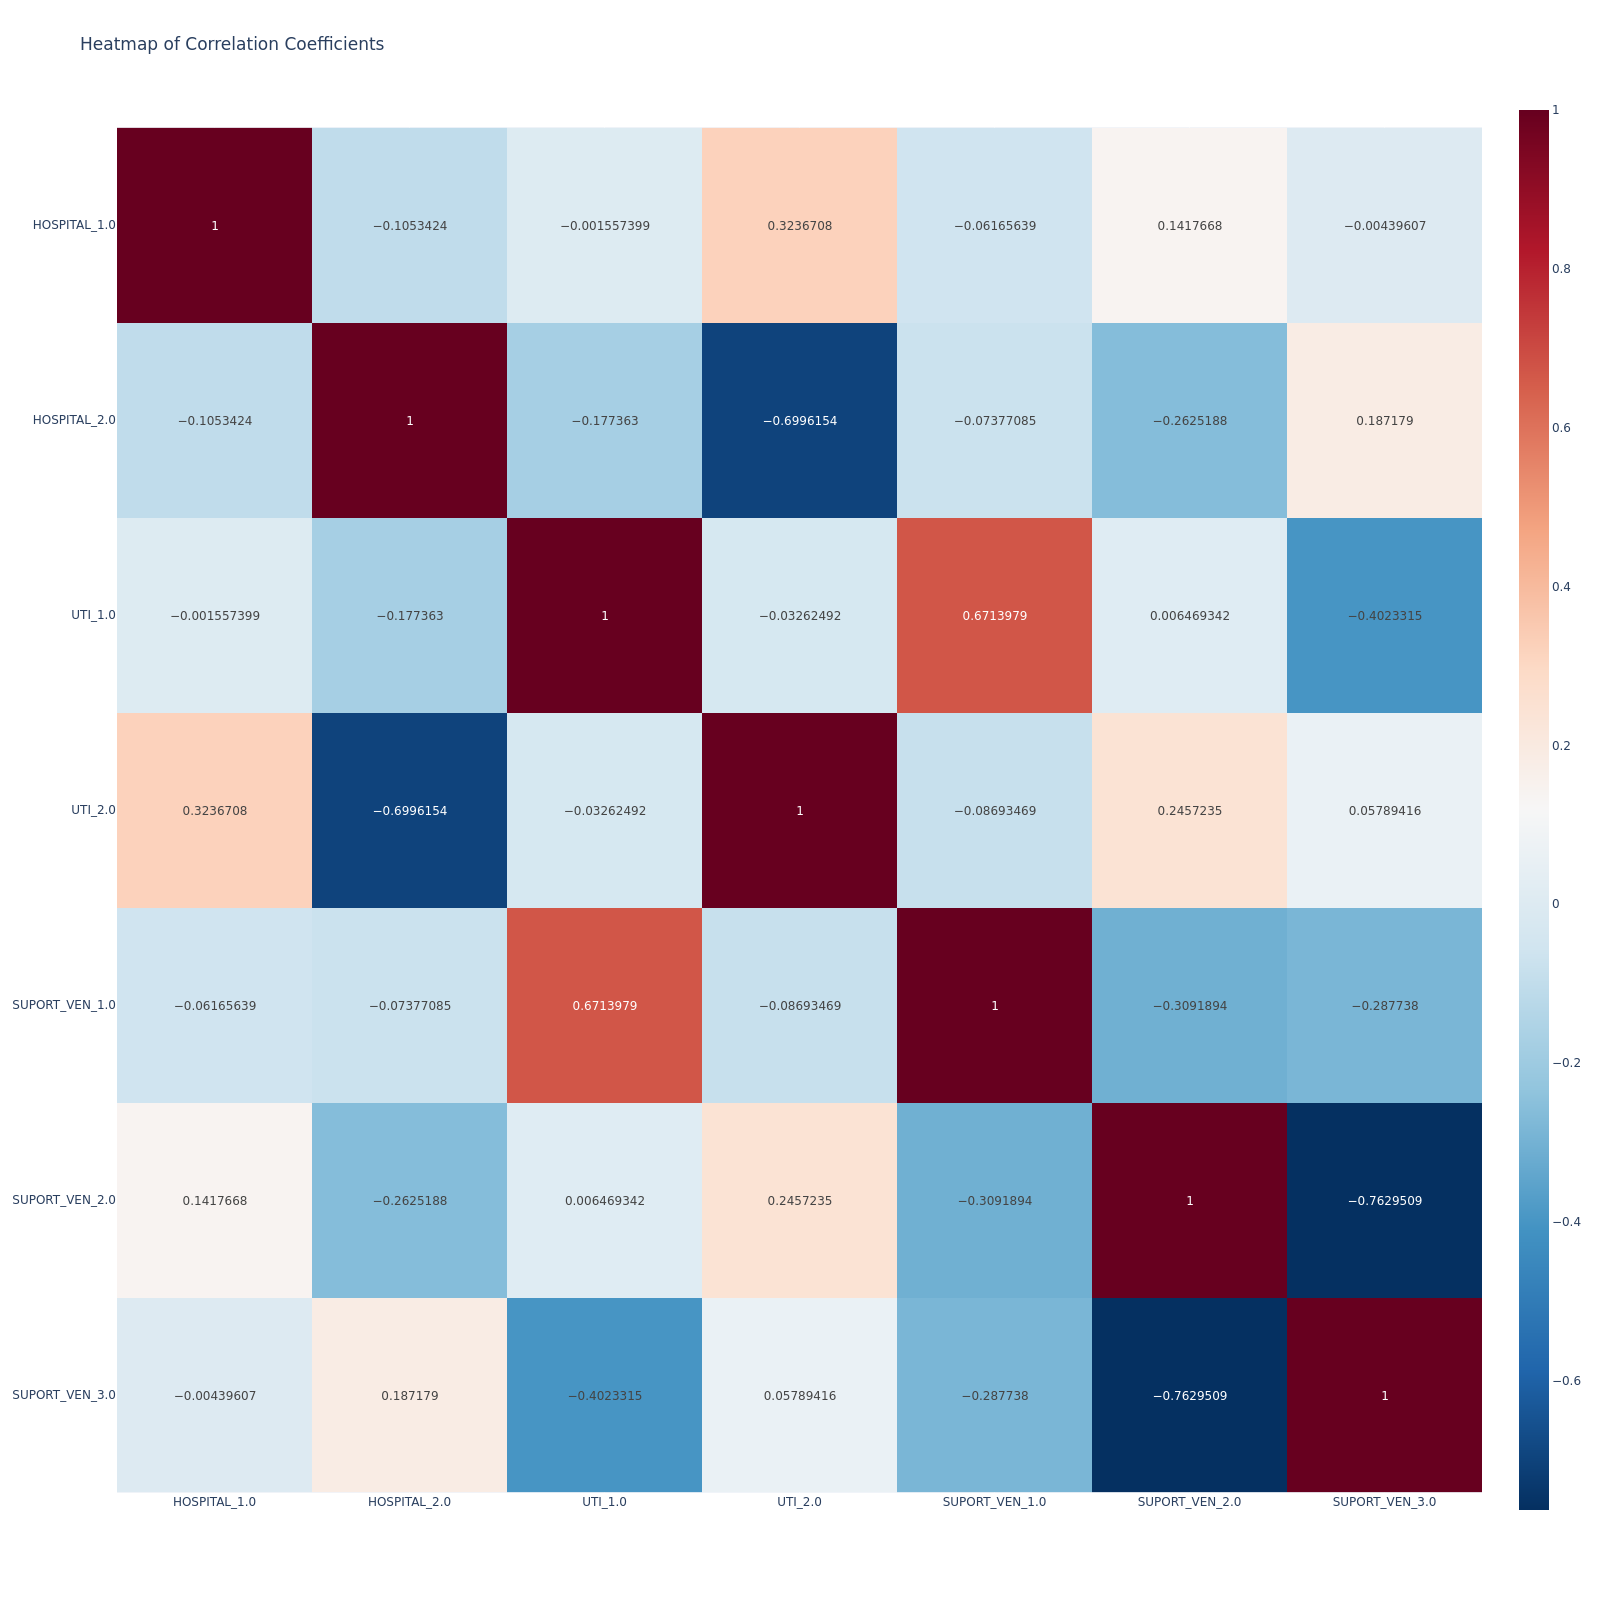

In [691]:
corr_heatmap(X_train.corr(numeric_only=True)[dummy_internacao], fig_type="png")

### Heatmap

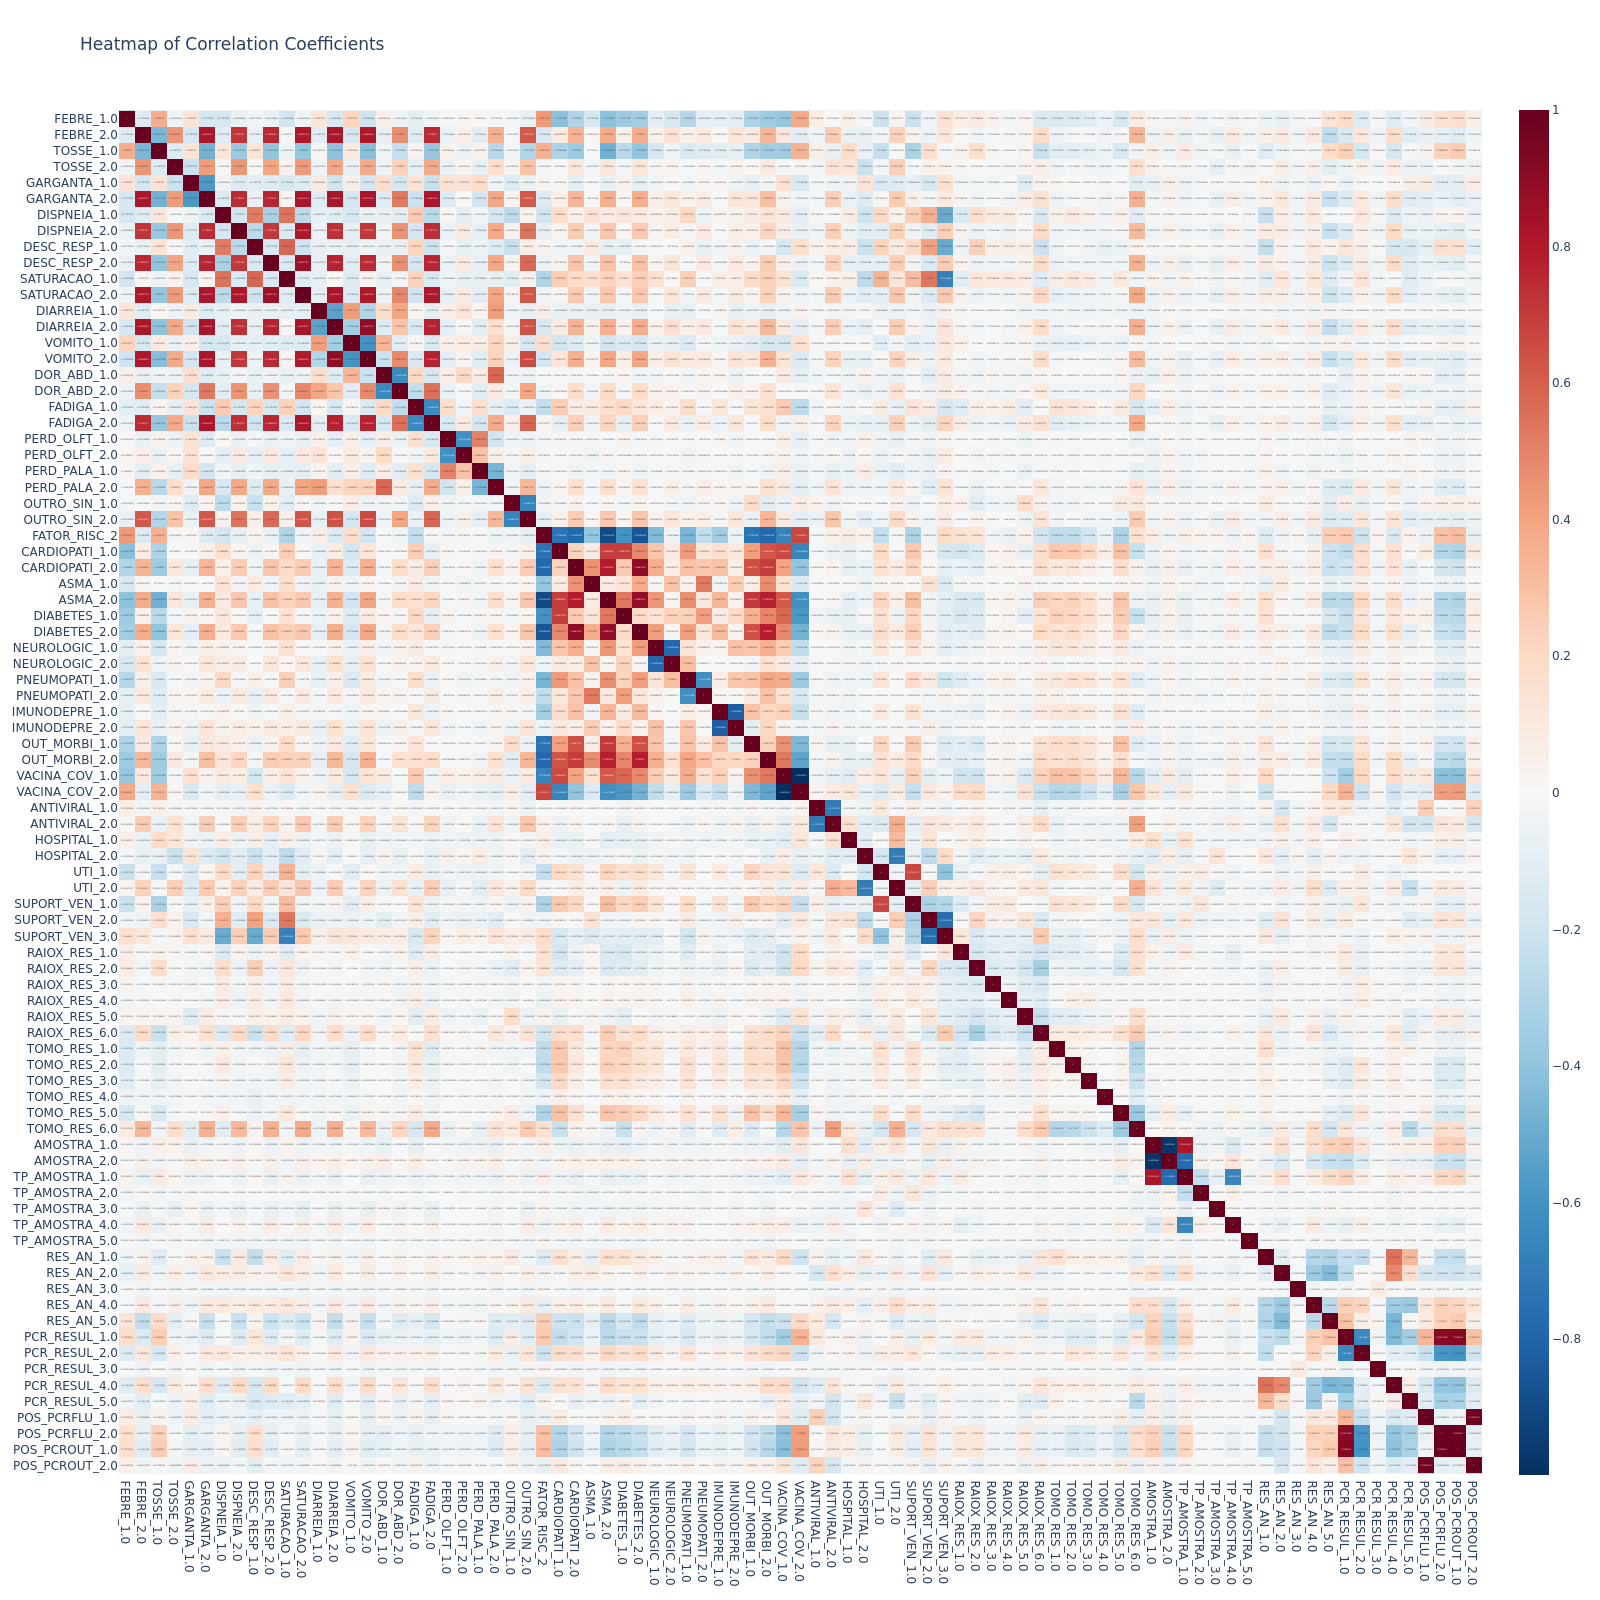

In [692]:
corr_heatmap(X_train.corr(numeric_only=True), fig_type="png")

In [693]:
def filtering_features_based_on_vif(X: np.ndarray, threshold=15.0, verbose=False):
    """
    Filter features based on Variance Inflation Factor (VIF).
    Features with VIF above the threshold are removed iteratively."""

    if not isinstance(threshold, (int, float)):
        raise ValueError("Threshold must be a numeric value.")
    if not isinstance(verbose, bool):
        raise ValueError("Verbose must be a boolean value.")
    if X.size == 0:
        raise ValueError("Input X cannot be empty.")
    if X.shape[0] < 2:
        raise ValueError("Input X must have at least two samples.")
    if X.shape[1] < 2:
        raise ValueError("Input X must have at least two features.")

    X = np.asanyarray(X)
    features = np.ones(X.shape[1], dtype=bool)
    for _ in tqdm(range(features.shape[0])):
        vif = np.zeros(features.shape[0])
        mask = np.where(features)
        vif[mask] = [variance_inflation_factor(X[:, features], i) for i in range(X[:, features].shape[1])]
        max_vif = max(vif)
        idx_max_vif = np.argmax(vif)
        if max_vif >= threshold:
            if verbose:
                print(f"Index of feature with max VIF: {idx_max_vif}")
                print(f"Removing feature with VIF: {max_vif}")
            features[idx_max_vif] = False
            continue
        else:
            break
    return features

In [694]:
sample = X_train.sample(40000)
mask_features = filtering_features_based_on_vif(sample.astype(float), threshold=5)
filtered_features = np.asarray(X_train.columns)[mask_features].tolist()

 18%|█▊        | 15/85 [03:29<16:15, 13.94s/it]


In [695]:
def generate_vif_dataframe(df, features):    
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) for i in range(df[features].shape[1])]
    vif_data["Tolerance"] = 1 / vif_data["VIF"]
    return vif_data

In [347]:
df_vif = generate_vif_dataframe(X_train, filtered_features)

In [348]:
df_vif.sort_values(by="Tolerance").head(20)

,feature,VIF,Tolerance
8,PNEUMOPATI_2.0,3.859576,0.259096
7,PNEUMOPATI_1.0,3.833036,0.260890
2,CARDIOPATI_2.0,3.815265,0.262105
5,NEUROLOGIC_1.0,3.636466,0.274992
6,NEUROLOGIC_2.0,3.514280,0.284553
12,OUT_MORBI_2.0,3.427835,0.291729
10,IMUNODEPRE_2.0,3.028925,0.330150
1,CARDIOPATI_1.0,2.761559,0.362114
9,IMUNODEPRE_1.0,2.589754,0.386137
11,OUT_MORBI_1.0,2.584875,0.386866


In [696]:
filtered_features

['FEBRE_1.0',
 'FEBRE_2.0',
 'TOSSE_2.0',
 'GARGANTA_1.0',
 'DISPNEIA_1.0',
 'DISPNEIA_2.0',
 'DESC_RESP_1.0',
 'DESC_RESP_2.0',
 'SATURACAO_1.0',
 'SATURACAO_2.0',
 'DIARREIA_1.0',
 'VOMITO_1.0',
 'DOR_ABD_1.0',
 'DOR_ABD_2.0',
 'FADIGA_1.0',
 'PERD_OLFT_1.0',
 'PERD_OLFT_2.0',
 'PERD_PALA_1.0',
 'PERD_PALA_2.0',
 'OUTRO_SIN_1.0',
 'OUTRO_SIN_2.0',
 'CARDIOPATI_1.0',
 'CARDIOPATI_2.0',
 'ASMA_1.0',
 'DIABETES_1.0',
 'NEUROLOGIC_1.0',
 'NEUROLOGIC_2.0',
 'PNEUMOPATI_1.0',
 'PNEUMOPATI_2.0',
 'IMUNODEPRE_1.0',
 'IMUNODEPRE_2.0',
 'OUT_MORBI_1.0',
 'OUT_MORBI_2.0',
 'VACINA_COV_1.0',
 'ANTIVIRAL_1.0',
 'ANTIVIRAL_2.0',
 'HOSPITAL_1.0',
 'HOSPITAL_2.0',
 'UTI_1.0',
 'UTI_2.0',
 'SUPORT_VEN_1.0',
 'SUPORT_VEN_3.0',
 'RAIOX_RES_1.0',
 'RAIOX_RES_2.0',
 'RAIOX_RES_3.0',
 'RAIOX_RES_4.0',
 'RAIOX_RES_5.0',
 'RAIOX_RES_6.0',
 'TOMO_RES_1.0',
 'TOMO_RES_2.0',
 'TOMO_RES_3.0',
 'TOMO_RES_4.0',
 'TOMO_RES_5.0',
 'TOMO_RES_6.0',
 'AMOSTRA_2.0',
 'TP_AMOSTRA_2.0',
 'TP_AMOSTRA_3.0',
 'TP_AMOSTRA_4.

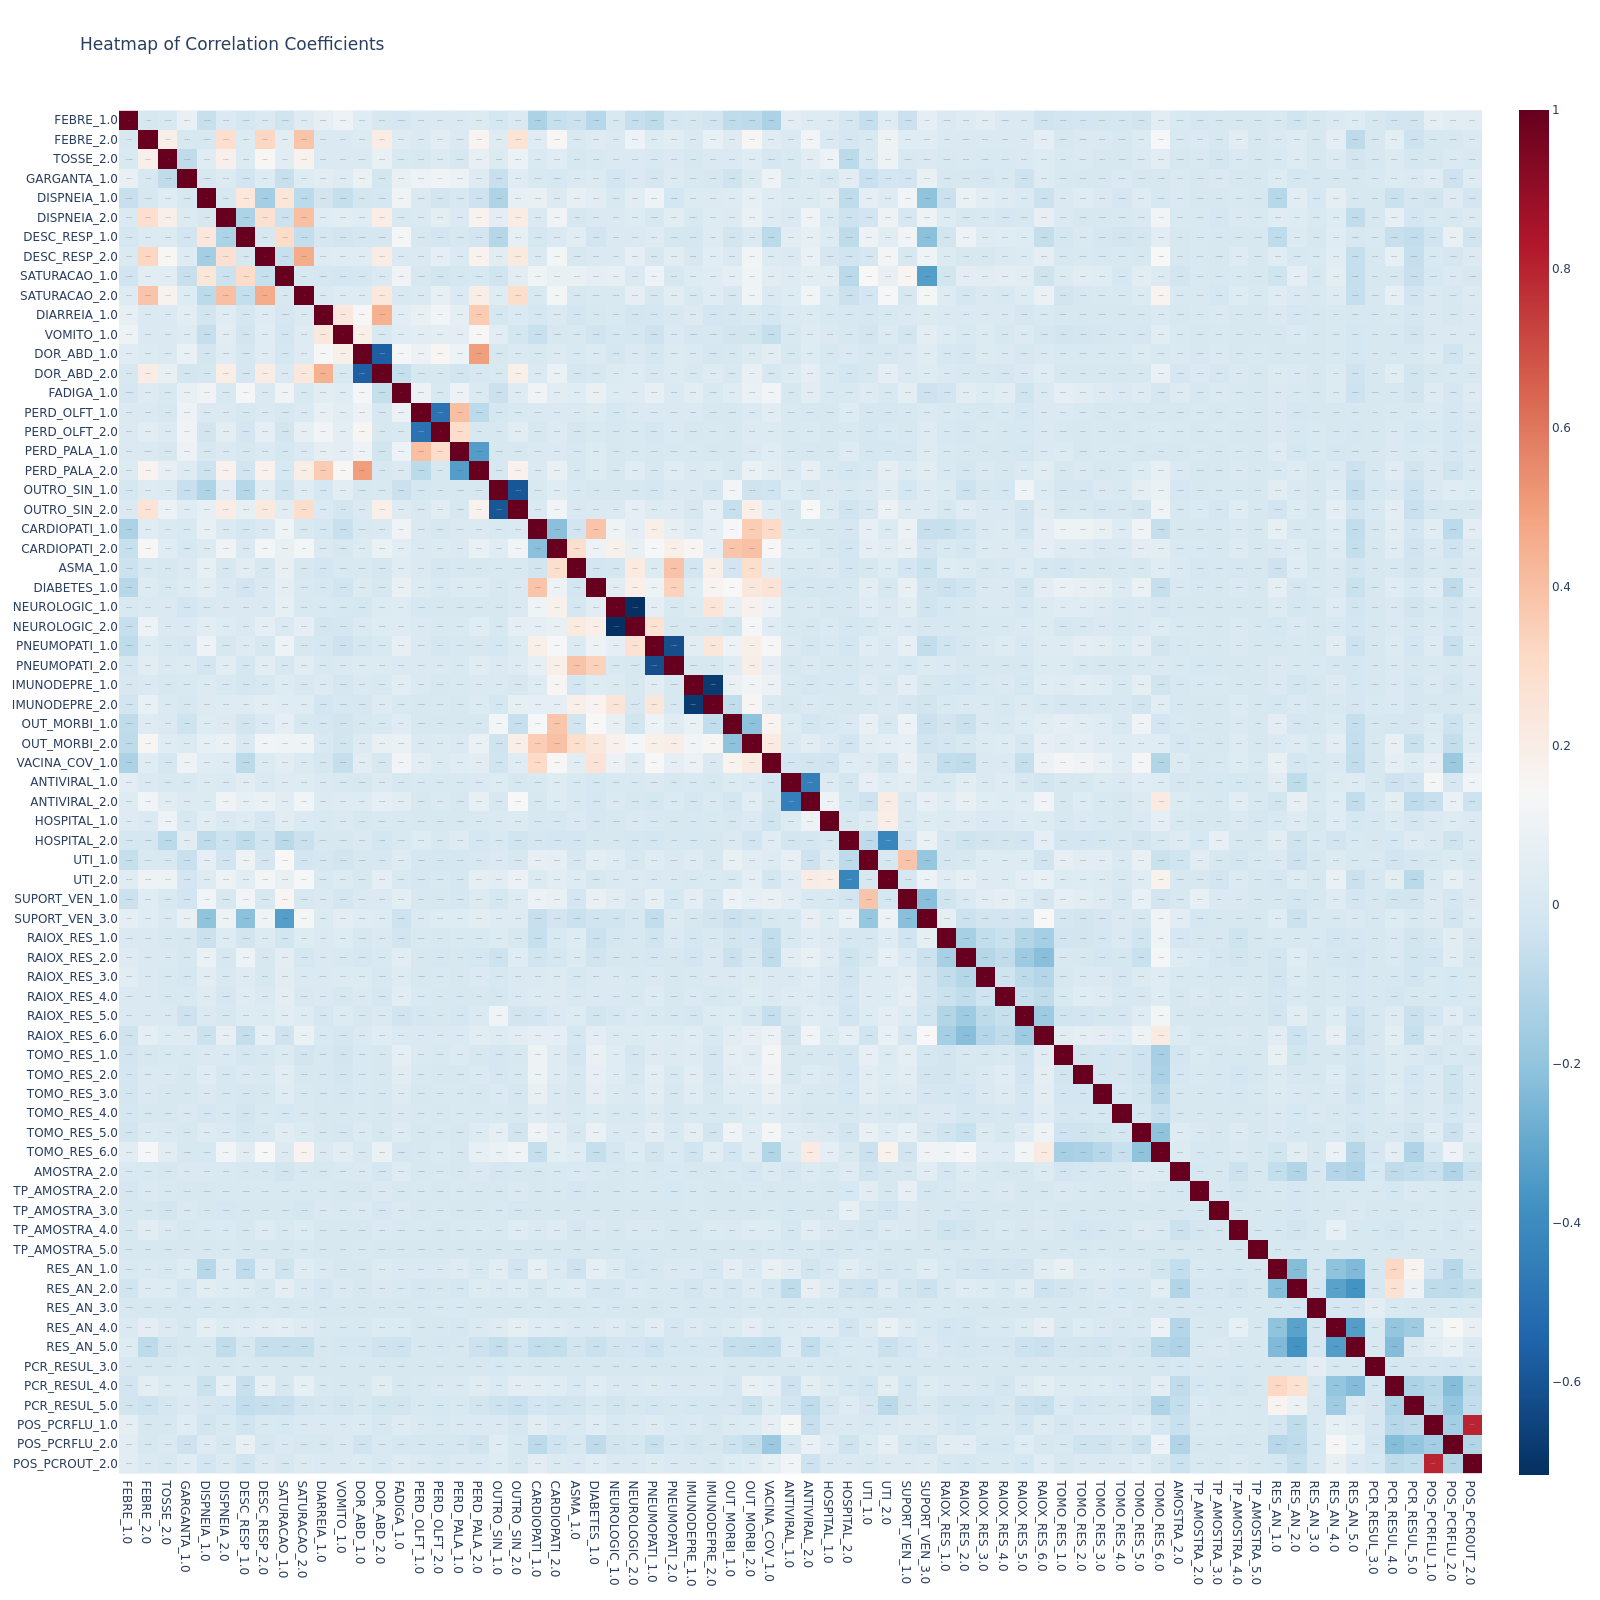

In [697]:
corr_heatmap(X_train[filtered_features], width=1600, height=1600, fig_type="png")

In [698]:
def plot_barplot_corr_with_target(X, y):
    X = X.copy()
    X[target] = y
    corr = X.corr(numeric_only=True)[target].drop(target).sort_values()
    plt.figure(figsize=(8, 12))
    sns.barplot(x=corr.values, y=corr.index, palette='RdBu_r')
    plt.title(f'Correlation Coefficients from {target}')
    plt.xlabel('Correlation Coefficients')
    plt.ylabel('Feature')
    plt.show()

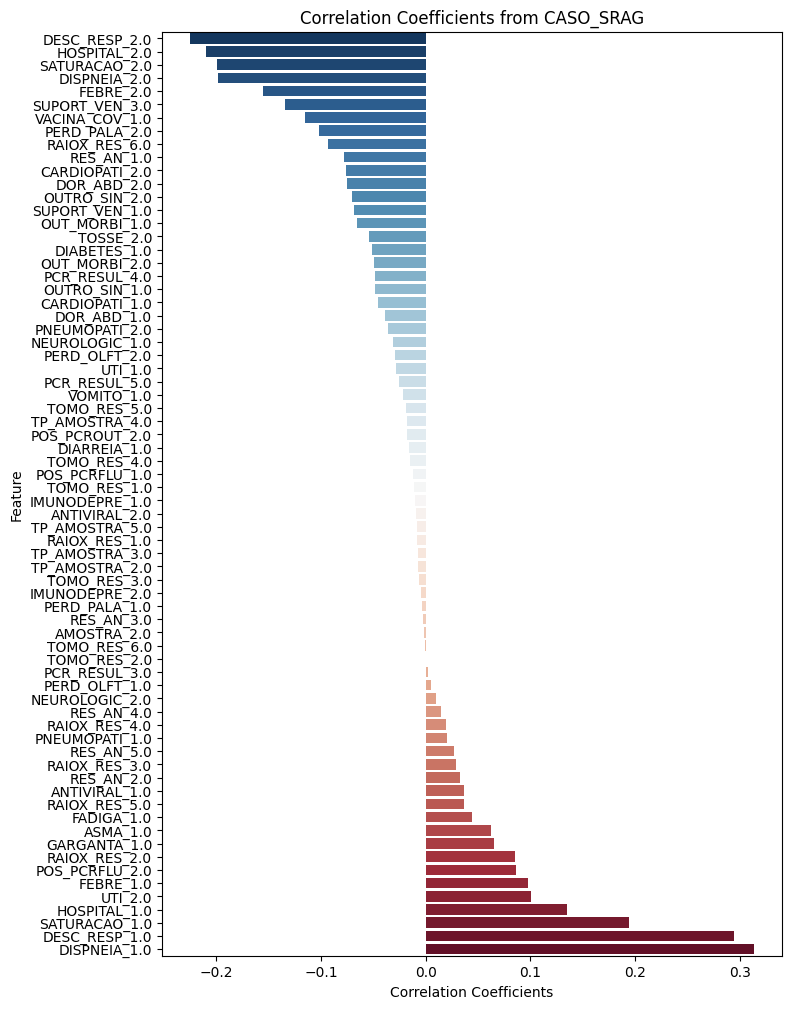

In [699]:
plot_barplot_corr_with_target(X_train[filtered_features], y_train)

# Modelling

In [700]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train[filtered_features], y_train)
model = TunedThresholdClassifierCV(
    model, scoring="matthews_corrcoef"
).fit(X_train[filtered_features], y_train)

In [701]:
matthews_corrcoef(y_test, model.predict(X_test[filtered_features]))

0.5182217263796117

In [702]:
model.best_threshold_

0.27204094863385425

In [703]:
def cm(clf, X, y, fig_type=None, percentage_by_class=True):
    """
    Generates an annotated heatmap of the confusion matrix for a classifier.

    Args:
        clf: Classifier object (e.g., sklearn classifier).
        X: Input features.
        y: True labels.
        alpha: Optional parameter for classifier prediction.
        fig_type: Optional figure type (e.g., 'png', 'svg').
        percentage_by_class: If True, displays percentages by class; otherwise, overall percentages.

    Returns:
        Annotated heatmap of the confusion matrix.
    """

    y_pred = clf.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    labels = np.array([["FN", "TN"], ["TP", "FP"]])
    cm = np.array([[fn, tn], [tp, fp]])

    if percentage_by_class:
        total = cm.sum(axis=0)
        percentage = cm / total * 100
    else:
        percentage = cm / np.sum(cm) * 100

    annotation_text = np.empty_like(percentage, dtype="U10")

    for i in range(percentage.shape[0]):
        for j in range(percentage.shape[1]):
            annotation_text[i, j] = f"{labels[i, j]} {percentage[i, j]:.2f}"

    fig = ff.create_annotated_heatmap(
        cm,
        x=["Positive", "Negative"],
        y=["Negative", "Positive"],
        colorscale="Blues",
        hoverinfo="z",
        annotation_text=annotation_text,
    )

    fig.update_layout(width=400, height=400, title="Confusion Matrix")
    return fig.show(fig_type)

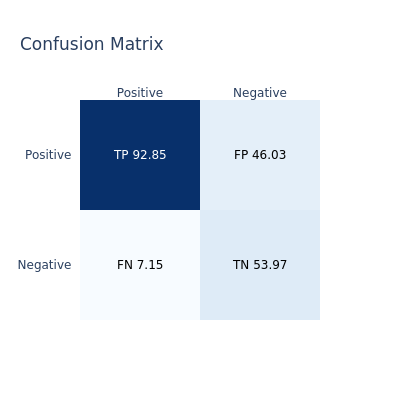

In [704]:
cm(model, X_test[filtered_features], y_test, fig_type="png")

## Análise de resíduo

In [705]:
odd_ratios = np.exp(model.estimator_.coef_)

In [706]:
results = pd.DataFrame({
    'feature': model.feature_names_in_,
    'std_coef': model.estimator_.coef_[0],
    'odd_ratio': np.exp(model.estimator_.coef_[0])
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)

In [707]:
results[results["odd_ratio"] > 1]

,feature,std_coef,odd_ratio
0,HOSPITAL_1.0,4.253903,70.379555
1,GARGANTA_1.0,1.325016,3.762245
2,DISPNEIA_1.0,1.201316,3.324490
3,DESC_RESP_1.0,0.906872,2.476565
4,ASMA_1.0,0.719216,2.052823
5,DIARREIA_1.0,0.622016,1.862680
6,FEBRE_1.0,0.542688,1.720626
7,POS_PCRFLU_2.0,0.349529,1.418399
8,SATURACAO_1.0,0.330388,1.391508
9,PNEUMOPATI_1.0,0.327287,1.387199


In [ ]:
"""
Aumentam a chance de SRAG:
Internação; (HOSPITAL)
Internação; (UTI)
Apresentar tosse; (TOSSE)
Apresentar DISPNEIA; (DISPNEIA)
Apresentar dor na garganta; (GARGANTA)
Apresentar desconforto respiratório; (DESC_RESP)
Apresentar saturação O2 < 95%; (SATURACAO)
Apresentar outros sintomas pode não configurar como SRAG; (OUTRO_SIN)
Não apresentar fadiga; (FADIGA)
"""


'\nAumentam a chance de SRAG:\nInternação; (HOSPITAL)\nInternação; (UTI)\nApresentar tosse; (TOSSE)\nApresentar DISPNEIA; (DISPNEIA)\nApresentar dor na garganta; (GARGANTA)\nApresentar desconforto respiratório; (DESC_RESP)\nApresentar saturação O2 < 95%; (SATURACAO)\nApresentar outros sintomas pode não configurar como SRAG; (OUTRO_SIN)\nNão apresentar fadiga; (FADIGA)\n'

In [ ]:
#Remover perda de paladar? Parece que a perda de paladar não 

In [ ]:
results[results["odd_ratio"] < 1].sort_values("odd_ratio")

,feature,std_coef,odd_ratio
22,TOSSE_2.0,-10.248801,0.000035
21,DISPNEIA_2.0,-3.301029,0.036845
20,DESC_RESP_2.0,-3.138268,0.043358
19,SATURACAO_2.0,-2.396038,0.091078
18,PERD_PALA_1.0,-0.428253,0.651647
17,PERD_OLFT_1.0,-0.405797,0.666445
16,DIARREIA_2.0,-0.384276,0.680943
15,DIARREIA_1.0,-0.338258,0.713011
14,FADIGA_1.0,-0.334540,0.715667
13,PERD_OLFT_2.0,-0.093954,0.910325


In [ ]:
"""
Diminuem a chance de SRAG:
Paciente não apresentar saturação O2 < 95%
Não apresentar tosse; (TOSSE)
Não houver desconforto respiratório; (DESC_RESP)
Não apresentar dispneia; (DISPNEIA)
Não apresentar dor na garganta; (GARGANTA)
Não apresentar perda do paladar; (PERD_PALA)
Apresentar outros sintomas pode não configurar como SRAG; (OUTRO_SIN)
Não apresentar fadiga; (FADIGA)
"""

'\nDiminuem a chance de SRAG:\nPaciente não apresentar saturação O2 < 95%\nNão apresentar tosse; (TOSSE)\nNão houver desconforto respiratório; (DESC_RESP)\nNão apresentar dispneia; (DISPNEIA)\nNão apresentar dor na garganta; (GARGANTA)\nNão apresentar perda do paladar; (PERD_PALA)\nApresentar outros sintomas pode não configurar como SRAG; (OUTRO_SIN)\nNão apresentar fadiga; (FADIGA)\n'

In [ ]:
X = sm.add_constant(X_train[filtered_features])  # adiciona intercepto
modelo = sm.Logit(y_train.values, X_train[filtered_features]).fit()

modelo.summary()

Optimization terminated successfully.
         Current function value: 0.264782
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               166144
Model:                          Logit   Df Residuals:                   166121
Method:                           MLE   Df Model:                           22
Date:                Tue, 29 Jul 2025   Pseudo R-squ.:                  0.5280
Time:                        07:03:00   Log-Likelihood:                -43992.
converged:                       True   LL-Null:                       -93198.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
FEBRE_1.0        -1.0835      0.034    -32.009      0.000      -1.150      -1.017
FEBRE_2.0         0.9182      0.023     40.434      0.000       0.874       0.963
TOSSE_1.0         5.1532      0.093     55.441      0.000       4.971       5.335
TOSSE_2.0        -7.2264      0.043   -167.255      0.000      -7.311      -7.142
GARGANTA_1.0      2.7740      0.056     49.848      0.000       2.665       2.883
GARGANTA_2.0      0.8531      0.050     17.153      0.000       0.756       0.951
DISPNEIA_1.0     -0.5705      0.036    -15.908      0.000      -0.641      -0.500
DISPNEIA_2.0     -2.1817      0.024    -89.728      0.000      -2.229      -2.134
DESC_RESP_1.0    -0.7372      0.035    -21.208      0.000      -0.805      -0.669
DESC_RESP_2.0    -2.2264      0.025    -89.947      0.000      -2.275      -2.178
SATURACAO_1.0    -0.5864      0.030    -19.354      0.000      -0.646      -0.527
SATURACAO_2.0    -0.6250      0.022    -28.470      0.000      -0.668      -0.582
DIARREIA_1.0      1.0882      0.059     18.562      0.000       0.973       1.203
DIARREIA_2.0      0.3778      0.057      6.580      0.000       0.265       0.490
VOMITO_1.0        0.6488      0.030     21.923      0.000       0.591       0.707
DOR_ABD_1.0       0.4044      0.071      5.669      0.000       0.265       0.544
DOR_ABD_2.0       0.3149      0.065      4.826      0.000       0.187       0.443
FADIGA_1.0        1.1976      0.027     43.721      0.000       1.144       1.251
PERD_OLFT_1.0    -1.9618      0.131    -14.921      0.000      -2.220      -1.704
PERD_OLFT_2.0    -1.6479      0.103    -16.073      0.000      -1.849      -1.447
PERD_PALA_1.0     1.0771      0.127      8.484      0.000       0.828       1.326
OUTRO_SIN_1.0     3.8699      0.030    128.061      0.000       3.811       3.929
OUTRO_SIN_2.0     3.9005      0.027    143.567      0.000       3.847       3.954
=================================================================================
"""

# RandomForestClassifier

In [708]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True, max_depth=int(np.ceil(np.log2(len(df_train)) - 1)), min_samples_leaf=5)
model.fit(X_train[filtered_features], y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,17
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [709]:
model = TunedThresholdClassifierCV(
    model, scoring="matthews_corrcoef"
).fit(X_train[filtered_features], y_train)

In [710]:
matthews_corrcoef(y_test, model.predict(X_test[filtered_features]))

0.9905668034345195

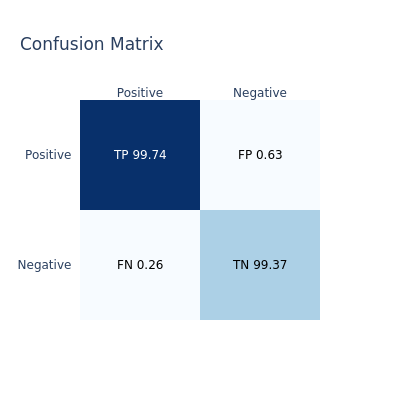

In [711]:
cm(model, X_test[filtered_features], y_test, fig_type="png")

In [712]:
results = pd.DataFrame({
    'feature': model.feature_names_in_,
    'feature_importance': model.estimator.feature_importances_,
}).sort_values(by='feature_importance', ascending=False).reset_index(drop=True)
results.head(15)

,feature,feature_importance
0,TOSSE_2.0,0.494784
1,DISPNEIA_2.0,0.085504
2,DESC_RESP_2.0,0.072608
3,DESC_RESP_1.0,0.061556
4,DISPNEIA_1.0,0.057264
5,SATURACAO_2.0,0.038581
6,SATURACAO_1.0,0.035940
7,HOSPITAL_1.0,0.029381
8,HOSPITAL_2.0,0.017716
9,GARGANTA_1.0,0.017307
